# Read data

In [1]:

import geopandas as gpd
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import time
import networkx as nx 
import folium
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')
pd.set_option('display.max_columns', 30)

In [2]:
data_rides = pd.read_csv("Zugfahrten_2016_12.csv", sep=";",  encoding='latin-1', date_parser="PROD_DATUM")
data_rides.columns = ["Station or stop", "Country", "Date", "Number of train rides", "Minutes of delay"]
data_rides = data_rides.sort_values(["Station or stop","Date"])

data_stations = pd.read_csv("GEO_Bahnstellen_EXPORT.csv", sep = ";", encoding = "latin-1")
data_stations.columns = ["Station or stop", "Name", "Country", "Coordinate Latitude", "Coordinate Longitude"]
data_stations = data_stations.sort_values(["Station or stop"])

In [3]:
# merge the two dataframes
data = pd.merge(data_rides, data_stations, on = "Station or stop")
data = data.drop(["Country_x"], axis = 1)

# rename the column "Country_y" to "Country"
data = data.rename(columns = {"Country_y": "Country"})

# Data cleaning

In [4]:
# Is this data reliable?
# maybe there are some stations that just not record the delay..
# calculate the sum of the Minutes of delay of each station
# over 600 out of 2565 station have no delayed at all. 
station = data.groupby("Station or stop")[['Minutes of delay']].sum().reset_index()
station
bins = [-1, 0, 100, 5000,40000]
station["bin"] = pd.cut(station["Minutes of delay"], bins=bins)
print(station.groupby("bin").count())
# zerosum_station = station[station['Minutes of delay'] == 0]["Station or stop"]
# delete the data of these 547 stations 
# data = data[~data["Station or stop"].isin(zerosum_station)]

               Station or stop  Minutes of delay
bin                                             
(-1, 0]                    638               638
(0, 100]                   238               238
(100, 5000]               1391              1391
(5000, 40000]              749               749


In [5]:
# 1) Include only values for Germany
data = data[data['Country'] == "DEUTSCHLAND"]
# check if it worked
print(len(data))
print(data['Country'].unique())

757228
['DEUTSCHLAND']


In [6]:
# 2) Missing values
# check for missing values
data.isnull().sum()
# drop rows with missing values
data = data.dropna(axis = 0, how = "any")
# check if it worked
print(len(data))
data.isnull().sum()

757007


Station or stop          0
Date                     0
Number of train rides    0
Minutes of delay         0
Name                     0
Country                  0
Coordinate Latitude      0
Coordinate Longitude     0
dtype: int64

In [7]:
data = data.sort_values((["Station or stop","Date"]))
data["Date"] = pd.to_datetime(data["Date"])


In [8]:
# exclude data in 2016-10-26 because every station has 0 delay 
data = data[data["Date"] != pd.to_datetime("2016-10-26")] 

In [9]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day 
data["Dayofweek"] = data["Date"].dt.weekday # Monday is 0 and Sunday is 6.

data["Meanofdelay"] = 	data["Minutes of delay"] / data["Number of train rides"]
data['Delay'] = np.where(data['Meanofdelay']>6,1,0)
# X= data[['Number of train rides','Month', 'Day', 'Dayofweek', 'Holidays','Meanrides']].reset_index(drop=True)

In [10]:
import holidays
Germany_holidays = holidays.Germany(years=2016)
Germany_holidays= pd.DataFrame.from_dict(Germany_holidays, orient='index').index.tolist()
# Germany_holidays
data['Holidays'] = 0
data.loc[data['Date'].isin(Germany_holidays),'Holidays'] = 1
#[i.isin(Germany_holidays) for i in data['Date']]


In [11]:
# calculate the percentile of number of traid rides per station 
Meanrides = data.groupby('Station or stop')['Number of train rides'].agg(
    p50_train_counts=lambda x: np.percentile(x, 50)).reset_index()
    # p75_train_counts=lambda x: np.percentile(x, 75),
    # p95_train_counts=lambda x: np.percentile(x, 95)



data =pd.merge(data, Meanrides, on="Station or stop")

# data["p75_train_counts"] = data["Number of train rides"]/data["p75_train_counts"]
# data["p95_train_counts"] = data["Number of train rides"]/data["p95_train_counts"]
data["p50_train_counts"] = data["Number of train rides"]/data["p50_train_counts"]

In [12]:
len(np.unique(data.Date))*0.95

304.0

In [13]:
# Stations that never experienced delays greater than zero throughout the entire duration were also excluded from the dataset.
station_data = data.groupby(['Station or stop'])['Minutes of delay'].agg(
    {'sum'}).sort_values("sum").reset_index()
station_data.columns = ["Station or stop", "sum of delay"]
allzero_station = station_data[station_data['sum of delay'] ==0]['Station or stop'].tolist()
data = data[~ data['Station or stop'].isin(allzero_station)]


In [14]:
station_data = data.groupby(['Station or stop'])['Date'].agg(
    {'nunique'}).sort_values("nunique").reset_index()

station_data.columns = ["Station or stop", "number of data of per Station"]
# sns.histplot(station_data, x= "number of data of per Station")

frenquent_station = station_data[station_data['number of data of per Station'] >= 304]['Station or stop'].tolist()
data = data[data['Station or stop'].isin(frenquent_station )]
data = data.sort_values(['Date','Station or stop']).reset_index(drop=True)

In [15]:

# drop columns that are not needed
data_mean = data.drop(columns = ["Date", "Country", "Coordinate Latitude", "Coordinate Longitude", "Name"])
data_mean = data_mean.groupby(["Station or stop"]).mean()

# get the names of the stations
data_names = data.drop(columns = ["Date", "Country", "Number of train rides", "Minutes of delay"])
data_names = data_names.drop_duplicates()

# merge the two dataframes
data_mean = pd.merge(data_names, data_mean, on = "Station or stop", how = "left")


In [16]:
data_mean = data[['Station or stop','Name', 'Country', 'Coordinate Latitude', 'Coordinate Longitude']].drop_duplicates(
).sort_values("Station or stop").reset_index(drop=True)
data_mean 
gdf_stations = gpd.GeoDataFrame(data_mean, geometry = gpd.points_from_xy(data_mean["Coordinate Longitude"], data_mean["Coordinate Latitude"]))
gdf_stations.head(2)

,Station or stop,Name,Country,Coordinate Latitude,Coordinate Longitude,geometry
0,80010694,HAMBURG-ROTHENBURGSORT,DEUTSCHLAND,53.537306,10.051834,POINT (10.05183 53.53731)
1,80010819,HAMBURG-WALTERSHOF,DEUTSCHLAND,53.520704,9.915370,POINT (9.91537 53.52070)


In [17]:
station_name = np.unique(data["Name"]).tolist()

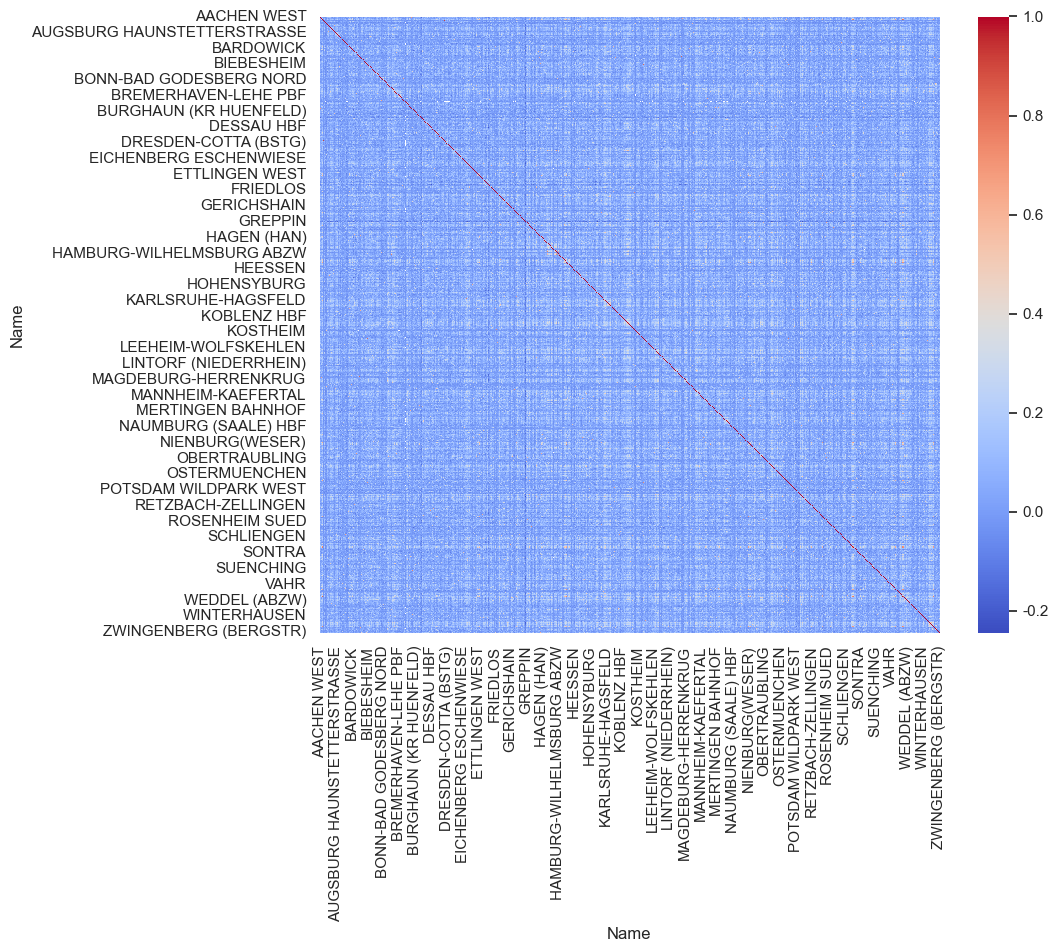

In [20]:
data2 = data.groupby(['Name', 'Date'])['Minutes of delay'].median().reset_index()
data2_pivot = pd.pivot(data2, columns="Name", index="Date", values="Minutes of delay")
corr = data2_pivot.corr()
sns.set(style="white")  
plt.rcParams.update({'font.size': 12})  # Adjust font size
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm")

plt.show()

# # plt.savefig('heatmap.png', bbox_inches='tight')


In [21]:
# correlation into source-target dataframe
corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_df = corr.reset_index()
corr_df = pd.melt(corr_df, id_vars=['Name'], var_name='Destination', value_name='Value')
corr_df.columns = ["source","target","value"]
corr_df = corr_df.dropna()

In [22]:
# remove correlation itself 
corr_df = corr_df[corr_df["value"]<1]
# set threshold 
corr_threshold = 0.4
corr_df = corr_df[corr_df["value"]> corr_threshold]
print(corr_df.shape)


(899, 3)


In [26]:
G = nx.from_pandas_edgelist(corr_df, 'source', 'target', ['value'])
deg_cent = nx.degree_centrality(G)
degrees = [len(list(G.neighbors(n))) for n in G.nodes()]
bet_cent = nx.betweenness_centrality(G)
deg_cent_df = pd.DataFrame(list(deg_cent.items()), columns=['station', 'deg_cent'])
bet_cent_df = pd.DataFrame(list(bet_cent.items()), columns=['station', 'bet_cent'])
network_df = pd.merge(deg_cent_df, bet_cent_df, on="station")
data1 = data.copy()
data1 = pd.merge(data1, network_df, left_on="Name", right_on="station", how="left")
data1 = data1.fillna(0)

In [27]:
# import msticpy as mp
# mp.init_notebook();
# corr_df.mp_plot.network(
#     source_col="source",
#     target_col="target",
#     edge_attrs=["value"],
#     title = "station network",
#     font_size=5,
#     scale=20
# )

In [28]:
# read germany border file 
germany_boundary = gpd.read_file("germany-detailed-boundary_917.geojson", crs = {'init': 'epsg:4326'} )

In [29]:
geometry = [Point(xy) for xy in zip(data['Coordinate Longitude'], data['Coordinate Latitude'])]
data['geometry'] = geometry
data = gpd.GeoDataFrame(data, geometry=geometry, crs = {'init': 'epsg:4326'})
data1 = data.copy()

/Users/jihakim/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [30]:
# create the distance_to_border 
data1['distance_to_border'] = data1.geometry.apply(lambda point: point.distance(germany_boundary.boundary))
# transform unit of distance to kilometers
data1['distance_to_border_km'] = data1['distance_to_border']*111

In [31]:
data1 = pd.merge(data1, network_df, left_on="Name", right_on="station")


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import train_test_split

x_columns = ['Month', 'Day', 'Dayofweek','Holidays','p50_train_counts',
             'Number of train rides',
             'distance_to_border_km',
             'deg_cent',
             'bet_cent']

# X_train, X_test, y_train, y_test  = train_test_split(data1.loc[:,x_columns], 
#                                                      data1.loc[:,'Delay'] , test_size=0.2, random_state=42)

# model = LogisticRegression(max_iter=5000)


# model.fit(X_train, y_train)


# y_pred = model.predict(X_test)

# # 정확도 계산
# accuracy = metrics.accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')


In [33]:
# undersampling 
from sklearn.utils import resample
data1 = data1.reset_index(drop=True)
X = data1[x_columns]
minority_class_count = len(data1[data1.loc[:,"Delay"] == 1])
idx_class_0 = np.where(data1.loc[:,"Delay"] == 0)[0]
idx_class_1 = np.where(data1.loc[:,"Delay"] == 1)[0]
downsampled_idx_class_0 = resample(idx_class_0, replace= False, n_samples=minority_class_count, random_state=42)
downsampled_X = pd.concat([X.iloc[downsampled_idx_class_0,:], X.iloc[idx_class_1,:]],axis=0)
downsampled_y = pd.concat([data1.loc[downsampled_idx_class_0,"Delay"], data1.loc[idx_class_1,"Delay"]],axis=0)


In [34]:

# train test split 
downsampled_X_train, downsampled_X_test, downsampled_y_train, downsampled_y_test = train_test_split(
    downsampled_X, downsampled_y , test_size=0.2, random_state=1)
model = LogisticRegression(max_iter=5000)
#fitting 
model.fit(downsampled_X_train, downsampled_y_train)
#prediction
downsampled_y_pred = model.predict(downsampled_X_test)

# 정확도 계산
accuracy = metrics.accuracy_score(downsampled_y_test, downsampled_y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5691768826619965


In [35]:
coefficients = model.coef_
intercept = model.intercept_
print("(Coef):", coefficients)
print("(Intercept):", intercept)


(Coef): [[ 1.83027037e-02  7.92377877e-03 -4.35542611e-02 -1.47390452e-01
   4.50690411e-01 -2.20968949e-03 -1.07722114e-03  5.61059289e+00
   9.12245504e+00]]
(Intercept): [-0.45306314]


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

rf = RandomForestClassifier()
rf.fit(downsampled_X_train, downsampled_y_train)

RandomForestClassifier()

In [37]:
downsampled_y_pred = rf.predict(downsampled_X_test)

In [38]:
accuracy = accuracy_score(downsampled_y_test, downsampled_y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.833041447752481


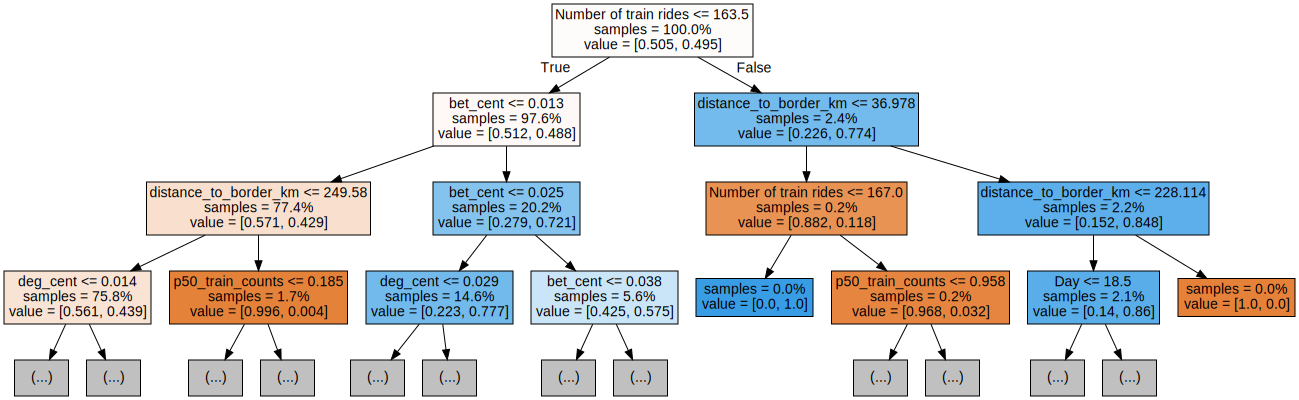

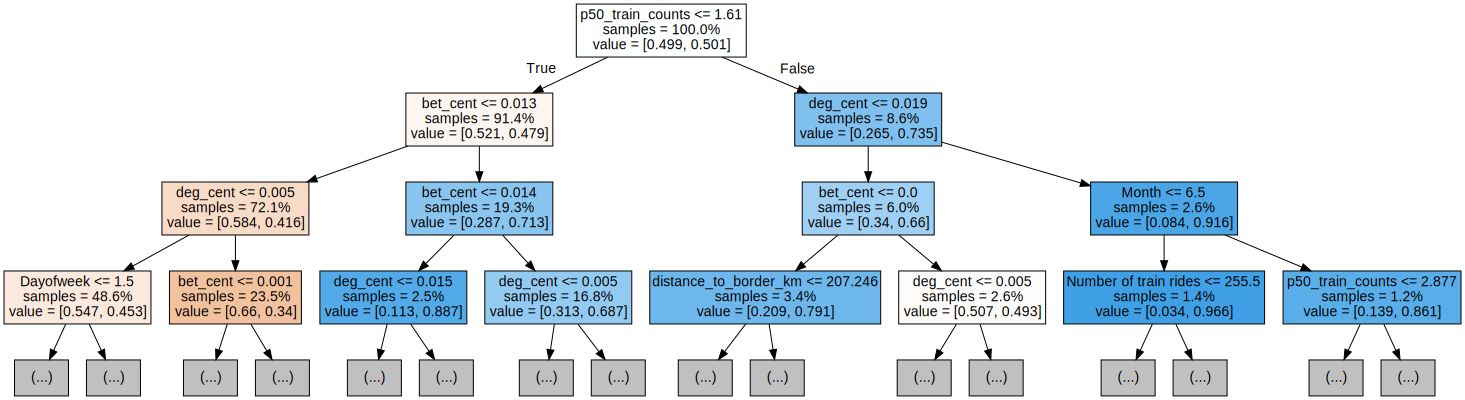

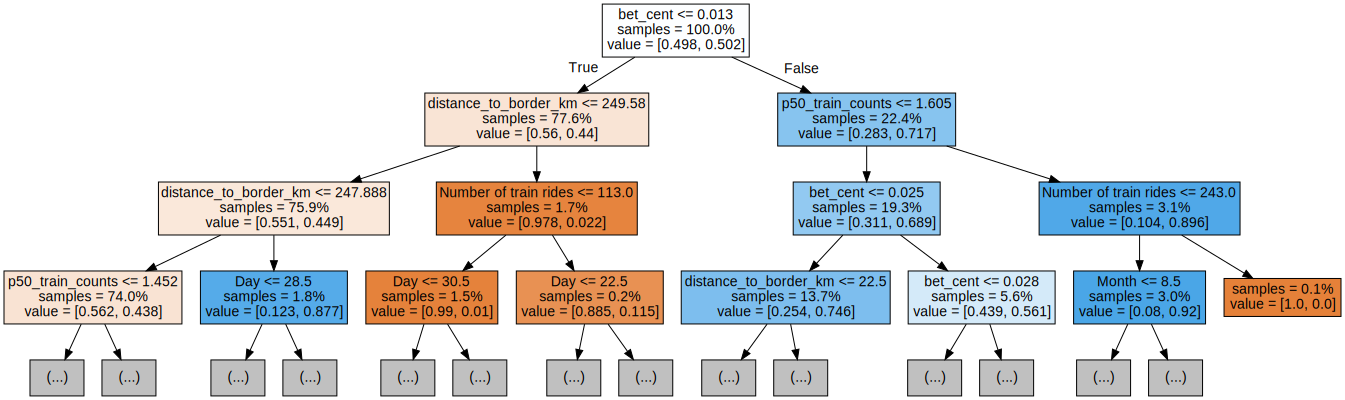

In [39]:

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=downsampled_X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

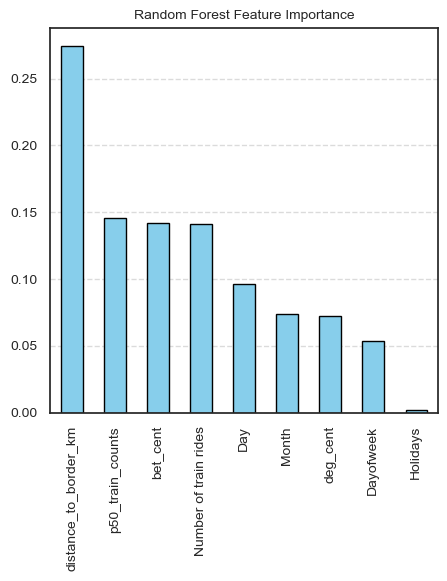

In [45]:
feature_importances = pd.Series(rf.feature_importances_,
                                index=downsampled_X_train.columns.tolist()).sort_values(ascending=False)
plt.figure(figsize=(5, 5))
feature_importances.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Random Forest Feature Importance', fontsize=10)
# plt.xlabel('Features', fontsize=14)
# plt.ylabel('Importance', fontsize=14)
plt.yticks(np.arange(0, 0.30, 0.05), size=10)
plt.xticks(size=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('feature_importance.pdf', format='pdf', bbox_inches='tight')
plt.show()

Degree centrality measures how well-connected a node is by counting the number of direct connections it has.
Betweenness centrality gauges the significance of a node by evaluating the number of shortest paths that pass through it, highlighting its potential influence in facilitating communication between other nodes in the network.